In [1]:
# Install core dependencies
!pip -q install --upgrade pip
!pip -q install wandb tqdm pandas matplotlib
!pip -q install torch torchvision --index-url https://download.pytorch.org/whl/cu121

# Clone and install the PerforatedAI library
!rm -rf /content/PerforatedAI
!git clone https://github.com/PerforatedAI/PerforatedAI.git /content/PerforatedAI
%cd /content/PerforatedAI
!pip -q install -e .

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 47.9 MB/s eta 0:00:00
Cloning into '/content/PerforatedAI'...
remote: Enumerating objects: 1383, done.
remote: Counting objects: 100% (339/339), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 1383 (delta 249), reused 230 (delta 230), pack-reused 1044 (from 2)
Receiving objects: 100% (1383/1383), 72.27 MiB | 15.13 MiB/s, done.
Resolving deltas: 100% (764/764), done.
/content/PerforatedAI
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for perforatedai (pyproject.toml) ... done


In [2]:
import os, time, copy, random
import numpy as np
import torch
import torch.nn as nn
import torchvision
from tqdm import tqdm
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from perforatedai import globals_perforatedai as GPA
from perforatedai import utils_perforatedai as UPA
import wandb

# --- CONFIGURATION & SEEDING ---
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

WANDB_PROJECT = "perforatedai-hackathon-cifar10-PR"

# --- RELIABILITY SETTINGS ---
# Bypass the "pdb" interactive trace and confirmed settings for headless Colab runs
GPA.pc.set_unwrapped_modules_confirmed(True)
GPA.pc.set_weight_decay_accepted(True)
GPA.pc.set_testing_dendrite_capacity(False)

Building dendrites without Perforated Backpropagation


In [3]:
mean = (0.4914, 0.4822, 0.4465)
std  = (0.2470, 0.2435, 0.2616)

# Added AutoAugment to reduce overfitting (CTO recommendation)
train_tfms = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(transforms.AutoAugmentPolicy.CIFAR10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_tfms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

train_ds = datasets.CIFAR10(root="./data", train=True, download=True, transform=train_tfms)
test_ds  = datasets.CIFAR10(root="./data", train=False, download=True, transform=test_tfms)

BATCH_SIZE = 128
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

100%|██████████| 170M/170M [00:20<00:00, 8.39MB/s]


In [6]:
def make_resnet18_cifar10():
    m = torchvision.models.resnet18(weights=None)
    m.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
    m.maxpool = nn.Identity()
    m.fc = nn.Linear(m.fc.in_features, 10)
    return m

def make_shufflenetv2_cifar10():
    m = torchvision.models.shufflenet_v2_x1_0(weights=None)
    m.fc = nn.Linear(m.fc.in_features, 10)
    return m

@torch.no_grad()
def evaluate_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    for x, y in loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        correct += (logits.argmax(dim=1) == y).sum().item()
        total += y.size(0)
    return correct / max(total, 1)

def count_params(model):
    return sum(p.numel() for p in model.parameters())

@torch.no_grad()
def benchmark_latency(model, loader, n_batches=30):
    model.eval()
    it = iter(loader)
    for _ in range(10): # Warmup
        x, _ = next(it)
        model(x.to(device))
    torch.cuda.synchronize()
    start = time.time()
    for _ in range(n_batches):
        x, _ = next(it)
        model(x.to(device))
    torch.cuda.synchronize()
    return (time.time() - start) / n_batches

In [7]:
def train_plain(model, run_name, lr=0.05, epochs=20):
    run = wandb.init(project=WANDB_PROJECT, name=run_name, reinit=True)
    model = model.to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
    criterion = nn.CrossEntropyLoss()

    best_acc = 0
    for epoch in range(epochs):
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()
        scheduler.step()

        test_acc = evaluate_accuracy(model, test_loader)
        if test_acc > best_acc: best_acc = test_acc
        wandb.log({"epoch": epoch, "test_acc": test_acc})
        print(f"[{run_name}] Epoch {epoch} Test Acc: {test_acc:.4f}")

    run.finish()
    return best_acc

In [8]:
def train_with_dendrites(model, run_name, lr=3e-4, safety_max_epochs=200):
    run = wandb.init(project=WANDB_PROJECT, name=run_name, reinit=True)
    model = UPA.initialize_pai(model) # Convert to PAI
    model = model.to(device)

    GPA.pai_tracker.set_optimizer(torch.optim.AdamW)
    GPA.pai_tracker.set_scheduler(torch.optim.lr_scheduler.ReduceLROnPlateau)

    optim_args = {"params": model.parameters(), "lr": lr, "weight_decay": 1e-4}
    sched_args = {"mode": "max", "patience": 5, "factor": 0.5}
    optimizer, _ = GPA.pai_tracker.setup_optimizer(model, optim_args, sched_args)

    criterion = nn.CrossEntropyLoss(label_smoothing=0.1) # Regularization
    restructured_epochs = []

    epoch = 0
    while epoch < safety_max_epochs:
        model.train()
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            optimizer.step()

        train_acc = evaluate_accuracy(model, train_loader)
        test_acc  = evaluate_accuracy(model, test_loader)

        # Log training score as requested
        GPA.pai_tracker.add_extra_score(train_acc, "Train Accuracy")
        model, restructured, training_complete = GPA.pai_tracker.add_validation_score(test_acc, model)
        model = model.to(device)

        if restructured:
            restructured_epochs.append(epoch)
            optimizer, _ = GPA.pai_tracker.setup_optimizer(model, optim_args, sched_args)

        wandb.log({"epoch": epoch, "train_acc": train_acc, "test_acc": test_acc})
        print(f"[C] Epoch {epoch} | Train: {train_acc:.4f} | Test: {test_acc:.4f}")

        if training_complete: break
        epoch += 1

    run.finish()
    return test_acc, restructured_epochs

In [9]:
# Run Baseline A
model_A = make_resnet18_cifar10()
acc_A = train_plain(model_A, "A_ResNet18")
lat_A = benchmark_latency(model_A, test_loader)

# Run Baseline B
model_B = make_shufflenetv2_cifar10()
acc_B = train_plain(model_B, "B_ShuffleNet")
lat_B = benchmark_latency(model_B, test_loader)

# Run Dendrite Model C
model_C = make_shufflenetv2_cifar10()
acc_C, restruct_C = train_with_dendrites(model_C, "C_ShuffleNet_Dendrites")
lat_C = benchmark_latency(model_C, test_loader)



/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 2


wandb: You chose 'Use an existing W&B account'
wandb: Logging into https://api.wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: Find your API key here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: warkevishal29 (warkevishal292) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: WARNING Using a boolean value for 'reinit' is deprecated. Use 'return_previous' or 'finish_previous' instead.


[A_ResNet18] Epoch 0 Test Acc: 0.4428
[A_ResNet18] Epoch 1 Test Acc: 0.5451
[A_ResNet18] Epoch 2 Test Acc: 0.7089
[A_ResNet18] Epoch 3 Test Acc: 0.7264
[A_ResNet18] Epoch 4 Test Acc: 0.7680
[A_ResNet18] Epoch 5 Test Acc: 0.7715
[A_ResNet18] Epoch 6 Test Acc: 0.8069
[A_ResNet18] Epoch 7 Test Acc: 0.8308
[A_ResNet18] Epoch 8 Test Acc: 0.8261
[A_ResNet18] Epoch 9 Test Acc: 0.8458
[A_ResNet18] Epoch 10 Test Acc: 0.8441
[A_ResNet18] Epoch 11 Test Acc: 0.8722
[A_ResNet18] Epoch 12 Test Acc: 0.8696
[A_ResNet18] Epoch 13 Test Acc: 0.8769
[A_ResNet18] Epoch 14 Test Acc: 0.8895
[A_ResNet18] Epoch 15 Test Acc: 0.9040
[A_ResNet18] Epoch 16 Test Acc: 0.9038
[A_ResNet18] Epoch 17 Test Acc: 0.9109
[A_ResNet18] Epoch 18 Test Acc: 0.9136
[A_ResNet18] Epoch 19 Test Acc: 0.9144


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_acc,▁▃▅▅▆▆▆▇▇▇▇▇▇▇██████
epoch,19
test_acc,0.9144


[B_ShuffleNet] Epoch 0 Test Acc: 0.3188
[B_ShuffleNet] Epoch 1 Test Acc: 0.3900
[B_ShuffleNet] Epoch 2 Test Acc: 0.4595
[B_ShuffleNet] Epoch 3 Test Acc: 0.4772
[B_ShuffleNet] Epoch 4 Test Acc: 0.5114
[B_ShuffleNet] Epoch 5 Test Acc: 0.5263
[B_ShuffleNet] Epoch 6 Test Acc: 0.5465
[B_ShuffleNet] Epoch 7 Test Acc: 0.5792
[B_ShuffleNet] Epoch 8 Test Acc: 0.5690
[B_ShuffleNet] Epoch 9 Test Acc: 0.5716
[B_ShuffleNet] Epoch 10 Test Acc: 0.5885
[B_ShuffleNet] Epoch 11 Test Acc: 0.6029
[B_ShuffleNet] Epoch 12 Test Acc: 0.6046
[B_ShuffleNet] Epoch 13 Test Acc: 0.5852
[B_ShuffleNet] Epoch 14 Test Acc: 0.6129
[B_ShuffleNet] Epoch 15 Test Acc: 0.6263
[B_ShuffleNet] Epoch 16 Test Acc: 0.6364
[B_ShuffleNet] Epoch 17 Test Acc: 0.6516
[B_ShuffleNet] Epoch 18 Test Acc: 0.6525
[B_ShuffleNet] Epoch 19 Test Acc: 0.6572


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_acc,▁▂▄▄▅▅▆▆▆▆▇▇▇▇▇▇████
epoch,19
test_acc,0.6572


Running Dendrite Experiment
Adding validation score 0.21640000
Checking PAI switch with mode n, switch mode DOING_HISTORY, epoch 0, last improved epoch 0, total epochs 0, n: 10, num_cycles: 0
Returning False - no triggers to switch have been hit
[C] Epoch 0 | Train: 0.1787 | Test: 0.2164
Adding validation score 0.28530000
Checking PAI switch with mode n, switch mode DOING_HISTORY, epoch 1, last improved epoch 1, total epochs 1, n: 10, num_cycles: 0
Returning False - no triggers to switch have been hit
[C] Epoch 1 | Train: 0.2309 | Test: 0.2853
Adding validation score 0.34140000
Checking PAI switch with mode n, switch mode DOING_HISTORY, epoch 2, last improved epoch 2, total epochs 2, n: 10, num_cycles: 0
Returning False - no triggers to switch have been hit
[C] Epoch 2 | Train: 0.2640 | Test: 0.3414
Adding validation score 0.37760000
Checking PAI switch with mode n, switch mode DOING_HISTORY, epoch 3, last improved epoch 3, total epochs 3, n: 10, num_cycles: 0
Returning False - no trig

epoch,▁▁▁▂▂▂▂▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█
test_acc,▁▃▄▅▅▆▇▇▇▇▇▇▇▇▇█▇███▇▇██████████████████
train_acc,▁▂▂▃▃▄▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇████████████
epoch,199
test_acc,0.7845
train_acc,0.757


NameError: name 'plt' is not defined

In [12]:
%matplotlib inline

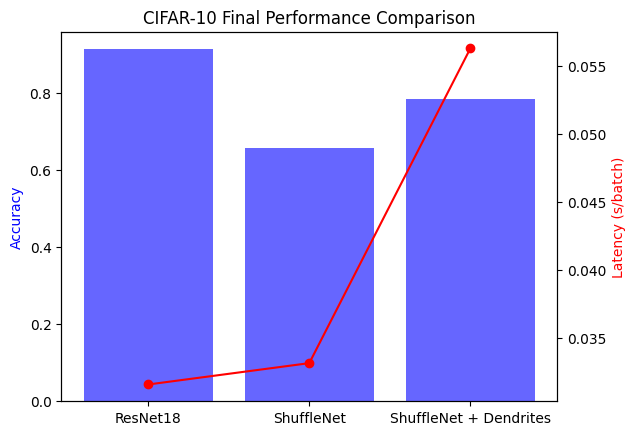

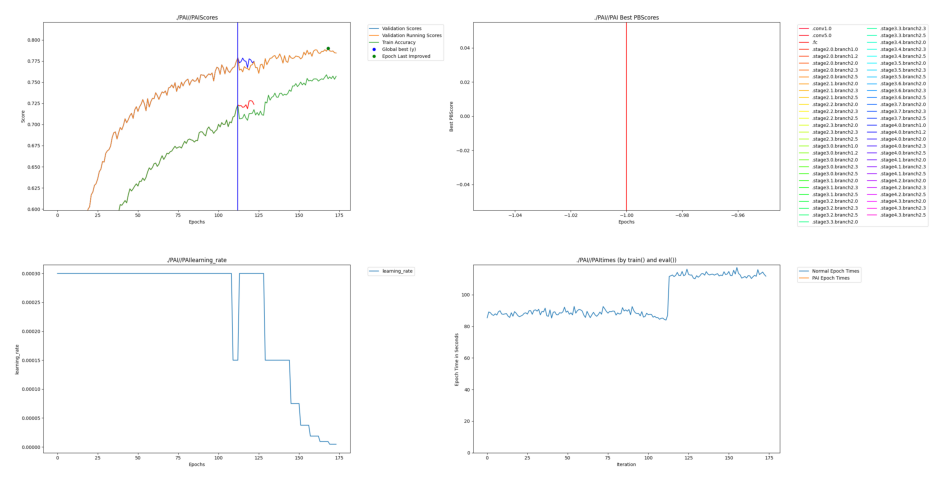

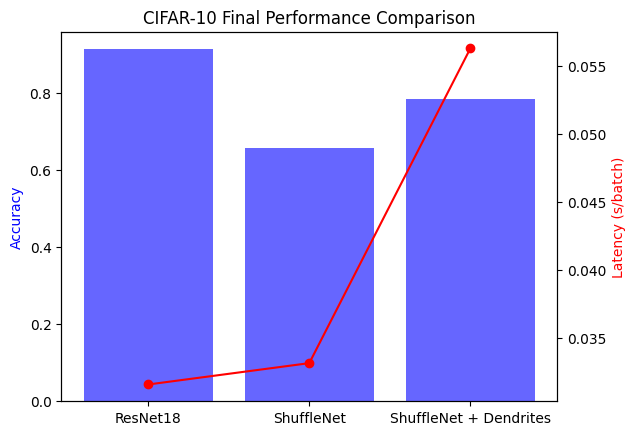

Final Comparison:
A: 0.9144
B: 0.6572
C: 0.7845


In [13]:
import matplotlib.pyplot as plt

# Final Visualization
labels = ['ResNet18', 'ShuffleNet', 'ShuffleNet + Dendrites']
accs = [acc_A, acc_B, acc_C]
lats = [lat_A, lat_B, lat_C]

fig, ax1 = plt.subplots()
ax1.bar(labels, accs, color='b', alpha=0.6, label='Accuracy')
ax1.set_ylabel('Accuracy', color='b')
ax2 = ax1.twinx()
ax2.plot(labels, lats, color='r', marker='o', label='Latency')
ax2.set_ylabel('Latency (s/batch)', color='r')
plt.title("CIFAR-10 Final Performance Comparison")
plt.show()

print(f"Final Comparison:\nA: {acc_A:.4f}\nB: {acc_B:.4f}\nC: {acc_C:.4f}")

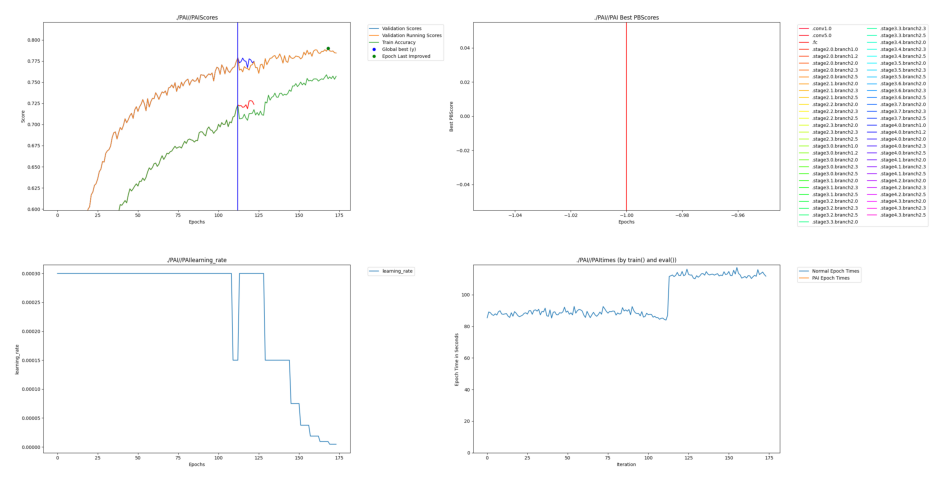

In [14]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("/content/PerforatedAI/PAI/PAI.png")
plt.figure(figsize=(18,6))
plt.imshow(img)
plt.axis("off")
plt.show()